## Prediction of Survival on the "Titanic"
### - Imputation, Feature Engineering, and Prediction using _XGBoost_

### Author: Junyuan Zheng
### Email: jz3036@cumc.columbia.edu

## About this session

- To prepare the data for the prediction models, this session first performed missing value impuation, after which feature engineering was conducted trying to extract more information from the original data available.
- I chose only one prediction model, which is __XGBoost__, to demonstrate the general process of grid search for choosing the hyperparameters of the model.
- Since XGBoost package contains a lot of parameters, I also wrote notes on some of the important ones.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [62]:
# import data
Data_train = pd.read_csv('./Dataset/train.csv')
Data_test = pd.read_csv('./Dataset/test.csv')

In [63]:
# import data
data_train = pd.read_csv('./Dataset/train.csv')
data_test = pd.read_csv('./Dataset/test.csv')

In [64]:
data_train.shape, data_test.shape

((891, 12), (418, 11))

In [65]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [66]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 1.6 Outliers

- From __1.5__ we saw that there are some outliers for continuous variables, such as 'Fare'.
- We can remove those outliers after the EDA.
- However, since the removal of outliers, which could also contain important info, is somewhat arbitrary, and tree models could handle outliers relatively better, I choose to leave those observations with outliers there for the time being and see how the models would perform first.

## 1.7 Missing Value Imputation

In [67]:
data_train.isnull().sum(), data_train.isnull().sum() / len(data_train)

(PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          687
 Embarked         2
 dtype: int64, PassengerId    0.000000
 Survived       0.000000
 Pclass         0.000000
 Name           0.000000
 Sex            0.000000
 Age            0.198653
 SibSp          0.000000
 Parch          0.000000
 Ticket         0.000000
 Fare           0.000000
 Cabin          0.771044
 Embarked       0.002245
 dtype: float64)

In [68]:
data_test.isnull().sum(), data_test.isnull().sum() / len(data_test)

(PassengerId      0
 Pclass           0
 Name             0
 Sex              0
 Age             86
 SibSp            0
 Parch            0
 Ticket           0
 Fare             1
 Cabin          327
 Embarked         0
 dtype: int64, PassengerId    0.000000
 Pclass         0.000000
 Name           0.000000
 Sex            0.000000
 Age            0.205742
 SibSp          0.000000
 Parch          0.000000
 Ticket         0.000000
 Fare           0.002392
 Cabin          0.782297
 Embarked       0.000000
 dtype: float64)

### 1.7.1 Missingness in 'Cabin'

- Both training and test dataset have a large portion of missingness.
- Given a large portion (70%+) of this variable are missing and it may need further feature engineering, I'm going to discard this variable.
- Instead, make a new variable __'Cabin_isnull'__ indicating the missingness, in case the missingness is not completely at random.

In [69]:
def bool_to_01(bool):
    return 1 if bool else 0

data_train['Cabin_isnull'] = data_train['Cabin'].isnull().map(bool_to_01)
data_test['Cabin_isnull'] = data_test['Cabin'].isnull().map(bool_to_01)

In [70]:
data_train.drop('Cabin', axis=1, inplace=True)
data_test.drop('Cabin', axis=1, inplace=True)

In [71]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_isnull
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1


In [72]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_isnull
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1


### 1.7.2 Missingness in 'Embarked'

- There are two missing values in the training dataset.
- According to __1.5.7__, since there are only two missing values, I'm going to impute those with 'S'.

In [73]:
data_train['Embarked'] = data_train['Embarked'].fillna('S')

In [74]:
data_train['Embarked'].isnull().sum()

0

### 1.7.3 Missingness in 'Fare'

- There are one missing value in the test dataset.
- According to __1.5.3__, since the distribution is skewed, I'm going to impute this value with median (of the training samples).

In [75]:
data_test['Fare'] = data_test['Fare'].fillna(data_train['Fare'].median())

In [76]:
data_test['Fare'].isnull().sum()

0

### 1.7.4 Missingness in 'Age'

- Both training and test dataset contain about 20% missing values.
- Make a new variable 'Age_isnull' indicating the missingness of 'Age'.
- Check the variable correlations with 'Age'.
- Pick some variables with relatively high correlation and regress 'Age' on those variables (or all if use regularization).
- Use the linear regression model to impute the missing values in both training and test dataset.

In [77]:
def bool_to_01(bool):
    return 1 if bool else 0

data_train['Age_isnull'] = data_train['Age'].isnull().map(bool_to_01)
data_test['Age_isnull'] = data_test['Age'].isnull().map(bool_to_01)

In [78]:
# get the dummy variables
data_train = pd.get_dummies(data_train, columns=['Sex'], drop_first=True)
data_train = pd.get_dummies(data_train, columns=['Pclass', 'Embarked']) # drop_first=False
data_test = pd.get_dummies(data_test, columns=['Sex'], drop_first=True)
data_test = pd.get_dummies(data_test, columns=['Pclass', 'Embarked']) # drop_first=False

In [79]:
data_train.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin_isnull,Age_isnull,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,0,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,1,0,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,0,0,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1,0,1,0,0,1,0,0,1


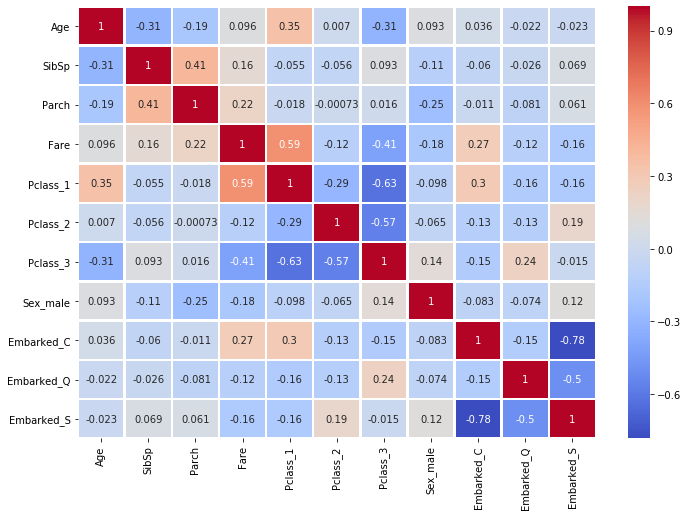

In [81]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1.5, 1.5])

sns.heatmap(
data_train[['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1',
            'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].corr(),
    annot=True, cmap='coolwarm', linewidth=1.5)
plt.show()

In [82]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [83]:
lasso = ElasticNet()

In [84]:
lasso_hp_grid = {'l1_ratio':[1],
             'alpha':list(np.arange(0,1.1,0.1))}

In [85]:
lasso_grid = GridSearchCV(ElasticNet(), lasso_hp_grid, cv=5, verbose=2)

In [86]:
lasso_grid.fit(X=data_train[-data_train['Age'].isnull()][['SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male',
                             'Embarked_Q', 'Embarked_S']],
               y=data_train[-data_train['Age'].isnull()]['Age'])

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV] alpha=0.0, l1_ratio=1 ...........................................
[CV] ............................ alpha=0.0, l1_ratio=1, total=   0.0s
[CV] alpha=0.0, l1_ratio=1 ...........................................
[CV] ............................ alpha=0.0, l1_ratio=1, total=   0.0s
[CV] alpha=0.0, l1_ratio=1 ...........................................
[CV] ............................ alpha=0.0, l1_ratio=1, total=   0.0s
[CV] alpha=0.0, l1_ratio=1 ...........................................
[CV] ............................ alpha=0.0, l1_ratio=1, total=   0.0s
[CV] alpha=0.0, l1_ratio=1 ...........................................
[CV] ............................ alpha=0.0, l1_ratio=1, total=   0.0s
[CV] alpha=0.1, l1_ratio=1 ...........................................
[CV] ............................ alpha=0.1, l1_ratio=1, total=   0.0s
[CV] alpha=0.1, l1_ratio=1 ...........................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45459.77747821984, tolerance: 11.741657951313485
  positive)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:515: UserWarning: With al

[CV] ............................ alpha=0.5, l1_ratio=1, total=   0.0s
[CV] alpha=0.5, l1_ratio=1 ...........................................
[CV] ............................ alpha=0.5, l1_ratio=1, total=   0.0s
[CV] alpha=0.5, l1_ratio=1 ...........................................
[CV] ............................ alpha=0.5, l1_ratio=1, total=   0.0s
[CV] alpha=0.6000000000000001, l1_ratio=1 ............................
[CV] ............. alpha=0.6000000000000001, l1_ratio=1, total=   0.0s
[CV] alpha=0.6000000000000001, l1_ratio=1 ............................
[CV] ............. alpha=0.6000000000000001, l1_ratio=1, total=   0.0s
[CV] alpha=0.6000000000000001, l1_ratio=1 ............................
[CV] ............. alpha=0.6000000000000001, l1_ratio=1, total=   0.0s
[CV] alpha=0.6000000000000001, l1_ratio=1 ............................
[CV] ............. alpha=0.6000000000000001, l1_ratio=1, total=   0.0s
[CV] alpha=0.6000000000000001, l1_ratio=1 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56497.520849225584, tolerance: 15.045663594411762
  positive)


GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,
                                   0.6000000000000001, 0.7000000000000001, 0.8,
                                   0.9, 1.0],
                         'l1_ratio': [1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [87]:
lasso_grid.best_score_

0.21126035464809884

In [88]:
lasso_grid.best_params_

{'alpha': 0.0, 'l1_ratio': 1}

In [ ]:
# impute 'Age' in training set

age_isnull_index_train = list(data_train[data_train['Age'].isnull()].index)
for i in age_isnull_index_train:
    age_pred = lasso_grid.predict(pd.DataFrame(data_train.iloc[i]).transpose()[['SibSp', 'Parch', 'Fare',
                                                                                'Pclass_2', 'Pclass_3', 'Sex_male',
                                                                                'Embarked_Q', 'Embarked_S']])[0]
    if age_pred >= 0:
        data_train['Age'][i] = age_pred
    else:
        data_train['Age'][i] = 1 # for some predictions that less than 0, assign '1'.
  

In [90]:
data_train['Age'].isnull().sum()

0

In [ ]:
# impute 'Age' in training set
age_isnull_index_test = list(data_test[data_test['Age'].isnull()].index)
for i in age_isnull_index_test:
    age_pred = lasso_grid.predict(pd.DataFrame(data_test.iloc[i]).transpose()[['SibSp', 'Parch', 'Fare',
                                                                                'Pclass_2', 'Pclass_3', 'Sex_male',
                                                                                'Embarked_Q', 'Embarked_S']])[0]
    if age_pred >= 0:
        data_test['Age'][i] = age_pred
    else:
        data_test['Age'][i] = 1 # for some predictions that less than 0, assign '1'.
  

In [92]:
data_test['Age'].isnull().sum()

0

In [93]:
data_train

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin_isnull,Age_isnull,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.000000,1,0,A/5 21171,7.2500,1,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.000000,1,0,PC 17599,71.2833,0,0,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.000000,0,0,STON/O2. 3101282,7.9250,1,0,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.000000,1,0,113803,53.1000,0,0,0,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.000000,0,0,373450,8.0500,1,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,"Montvila, Rev. Juozas",27.000000,0,0,211536,13.0000,1,0,1,0,1,0,0,0,1
887,888,1,"Graham, Miss. Margaret Edith",19.000000,0,0,112053,30.0000,0,0,0,1,0,0,0,0,1
888,889,0,"Johnston, Miss. Catherine Helen ""Carrie""",20.220291,1,2,W./C. 6607,23.4500,1,1,0,0,0,1,0,0,1
889,890,1,"Behr, Mr. Karl Howell",26.000000,0,0,111369,30.0000,0,0,1,1,0,0,1,0,0


## 1.8 Feature Engineering

### 1.8.1 'Name'

- Extract the title from each name and try to group them.

In [94]:
L_nametitle_train = [i.split(",")[1].split(".")[0].strip() for i in data_train['Name']]
L_nametitle_test = [i.split(",")[1].split(".")[0].strip() for i in data_test['Name']]

In [95]:
data_train['Title'] = pd.Series(L_nametitle_train)
data_test['Title'] = pd.Series(L_nametitle_test)
data_train.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin_isnull,Age_isnull,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,0,1,0,0,1,0,0,1,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,0,0,1,0,0,1,0,0,Mrs
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,1,0,0,0,0,1,0,0,1,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,0,0,1,0,0,0,0,1,Mrs
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1,0,1,0,0,1,0,0,1,Mr


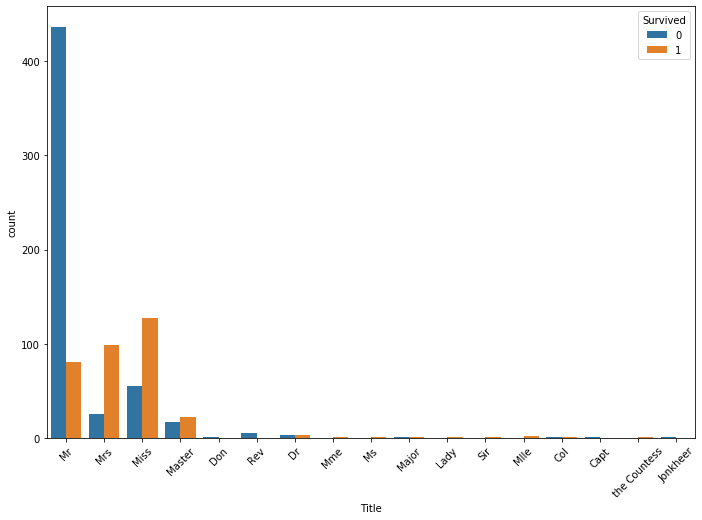

In [96]:
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
sns.countplot(x='Title', data=data_train, hue='Survived')
plt.show()

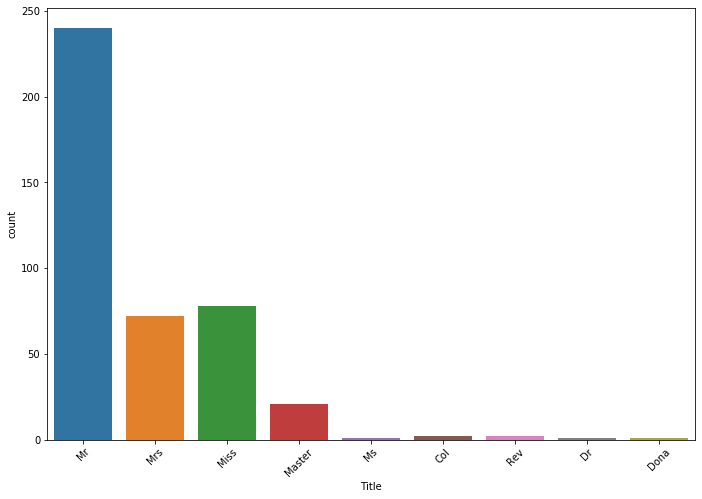

In [97]:
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
sns.countplot(x='Title', data=data_test)
plt.show()

In [98]:
data_train['Title'] = data_train['Title'].replace(
    ['Mr', 'Don','Rev', 'Capt', 'Jonkheer'], 'Gentleman')
data_train['Title'] = data_train['Title'].replace(
    ['Mrs', 'Miss', 'Ms', 'Mme', 'Lady', 'Mlle', 'Dona'], 'Lady')
data_train['Title'] = data_train['Title'].replace(
    ['Dr', 'Major', 'Sir', 'Col', 'the Countess'], 'Others')

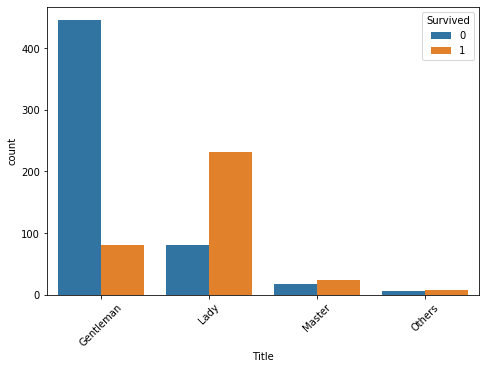

In [99]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
sns.countplot(x='Title', data=data_train, hue='Survived')
plt.show()

In [100]:
data_test['Title'] = data_test['Title'].replace(
    ['Mr', 'Don','Rev', 'Capt', 'Jonkheer'], 'Gentleman')
data_test['Title'] = data_test['Title'].replace(
    ['Mrs', 'Miss', 'Ms', 'Mme', 'Lady', 'Mlle', 'Dona'], 'Lady')
data_test['Title'] = data_test['Title'].replace(
    ['Dr', 'Major', 'Sir', 'Col', 'the Countess'], 'Others')

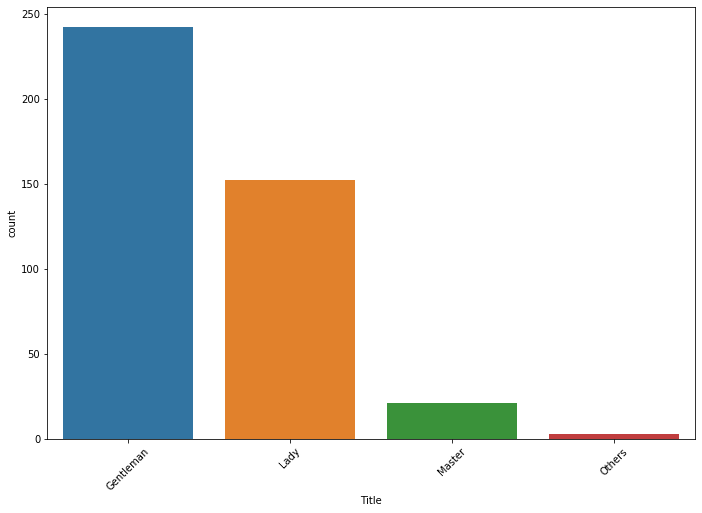

In [101]:
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
sns.countplot(x='Title', data=data_test)
plt.show()

In [103]:
data_train.drop('Name', axis=1, inplace=True)
data_test.drop('Name', axis=1, inplace=True)

In [104]:
# get dummies
data_train = pd.get_dummies(data_train, columns=['Title']) # drop_first=False
data_test = pd.get_dummies(data_test, columns=['Title']) # drop_first=False

### 1.8.2 'Fare'

- According to __1.5.3__, do a log transformation to 'Fare'

In [105]:
data_train['Fare'] = data_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

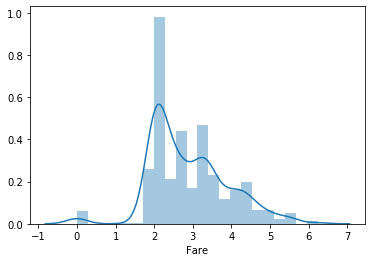

In [106]:
sns.distplot(data_train['Fare'])
plt.show()

In [107]:
data_test['Fare'] = data_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

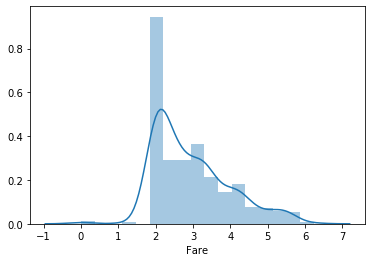

In [108]:
sns.distplot(data_test['Fare'])
plt.show()

In [109]:
data_train

,PassengerId,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin_isnull,Age_isnull,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Gentleman,Title_Lady,Title_Master,Title_Others
0,1,0,22.000000,1,0,A/5 21171,1.981001,1,0,1,0,0,1,0,0,1,1,0,0,0
1,2,1,38.000000,1,0,PC 17599,4.266662,0,0,0,1,0,0,1,0,0,0,1,0,0
2,3,1,26.000000,0,0,STON/O2. 3101282,2.070022,1,0,0,0,0,1,0,0,1,0,1,0,0
3,4,1,35.000000,1,0,113803,3.972177,0,0,0,1,0,0,0,0,1,0,1,0,0
4,5,0,35.000000,0,0,373450,2.085672,1,0,1,0,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,27.000000,0,0,211536,2.564949,1,0,1,0,1,0,0,0,1,1,0,0,0
887,888,1,19.000000,0,0,112053,3.401197,0,0,0,1,0,0,0,0,1,0,1,0,0
888,889,0,20.220291,1,2,W./C. 6607,3.154870,1,1,0,0,0,1,0,0,1,0,1,0,0
889,890,1,26.000000,0,0,111369,3.401197,0,0,1,1,0,0,1,0,0,1,0,0,0


In [110]:
data_test

,PassengerId,Age,SibSp,Parch,Ticket,Fare,Cabin_isnull,Age_isnull,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Gentleman,Title_Lady,Title_Master,Title_Others
0,892,34.500000,0,0,330911,2.057860,1,0,1,0,0,1,0,1,0,1,0,0,0
1,893,47.000000,1,0,363272,1.945910,1,0,0,0,0,1,0,0,1,0,1,0,0
2,894,62.000000,0,0,240276,2.270836,1,0,1,0,1,0,0,1,0,1,0,0,0
3,895,27.000000,0,0,315154,2.159003,1,0,1,0,0,1,0,0,1,1,0,0,0
4,896,22.000000,1,1,3101298,2.508582,1,0,0,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,28.890429,0,0,A.5. 3236,2.085672,1,1,1,0,0,1,0,0,1,1,0,0,0
414,1306,39.000000,0,0,PC 17758,4.690430,0,0,0,1,0,0,1,0,0,0,1,0,0
415,1307,38.500000,0,0,SOTON/O.Q. 3101262,1.981001,1,0,1,0,0,1,0,0,1,1,0,0,0
416,1308,28.890429,0,0,359309,2.085672,1,1,1,0,0,1,0,0,1,1,0,0,0


### 1.8.3 drop 'PassengerId', 'Ticket'

In [111]:
data_train.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)

In [112]:
data_test.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)

In [113]:
data_train.head()

,Survived,Age,SibSp,Parch,Fare,Cabin_isnull,Age_isnull,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Gentleman,Title_Lady,Title_Master,Title_Others
0,0,22.0,1,0,1.981001,1,0,1,0,0,1,0,0,1,1,0,0,0
1,1,38.0,1,0,4.266662,0,0,0,1,0,0,1,0,0,0,1,0,0
2,1,26.0,0,0,2.070022,1,0,0,0,0,1,0,0,1,0,1,0,0
3,1,35.0,1,0,3.972177,0,0,0,1,0,0,0,0,1,0,1,0,0
4,0,35.0,0,0,2.085672,1,0,1,0,0,1,0,0,1,1,0,0,0


In [114]:
data_test.head()

,Age,SibSp,Parch,Fare,Cabin_isnull,Age_isnull,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Gentleman,Title_Lady,Title_Master,Title_Others
0,34.5,0,0,2.057860,1,0,1,0,0,1,0,1,0,1,0,0,0
1,47.0,1,0,1.945910,1,0,0,0,0,1,0,0,1,0,1,0,0
2,62.0,0,0,2.270836,1,0,1,0,1,0,0,1,0,1,0,0,0
3,27.0,0,0,2.159003,1,0,1,0,0,1,0,0,1,1,0,0,0
4,22.0,1,1,2.508582,1,0,0,0,0,1,0,0,1,0,1,0,0


# 2 Model Training

In [115]:
y_train = data_train['Survived']
X_train = data_train.drop('Survived', axis=1)

In [116]:
X_train.head()

,Age,SibSp,Parch,Fare,Cabin_isnull,Age_isnull,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Gentleman,Title_Lady,Title_Master,Title_Others
0,22.0,1,0,1.981001,1,0,1,0,0,1,0,0,1,1,0,0,0
1,38.0,1,0,4.266662,0,0,0,1,0,0,1,0,0,0,1,0,0
2,26.0,0,0,2.070022,1,0,0,0,0,1,0,0,1,0,1,0,0
3,35.0,1,0,3.972177,0,0,0,1,0,0,0,0,1,0,1,0,0
4,35.0,0,0,2.085672,1,0,1,0,0,1,0,0,1,1,0,0,0


## 2.1 XGBoost

### XGBoost - w/o Tuning

In [117]:
import xgboost as xgb

In [118]:
xgb_model = xgb.XGBClassifier()

In [119]:
xgb_model.fit(X=X_train, y=y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

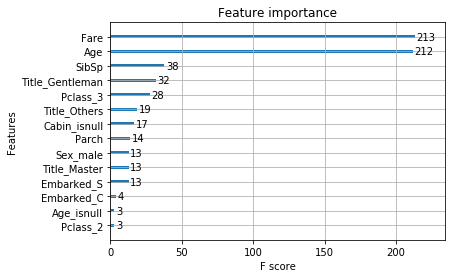

In [120]:
# variable importance
xgb.plot_importance(xgb_model)

In [121]:
# prediction on the test set
test_predict = pd.Series(xgb_model.predict(data_test), name="Survived")
id = Data_test['PassengerId']

prediction = pd.concat([id, test_predict], axis=1)

In [123]:
# generate output file
prediction.to_csv('prediction_xgb.csv', index=False)

### XGBoost - w/ Tuning

In [153]:
from sklearn.model_selection import GridSearchCV

- __booster__: choose booster, can be 'gbtree', 'gblinear' or 'dart'. Usually 'gbtree'.
- __n_estimators__: Number of gradient boosted trees. Equivalent to number of boosting rounds.

- __learning_rate / eta__: Step size shrinkage used in update to prevents overfitting. Range [0, 1].
- __gamma / min_split_loss__: Minimum loss reduction required to make a further partition on a leaf node of the tree. Prune if 'Similarity gain' - gamma > 0. Range [0, +].
- __min_child_weight / Cover__: Minimum sum of instance weight (hessian) needed in a child. Range [0, +].
- __lambda / reg_lambda__: L2 regularization term on weights. Default 1.
- __alpha / reg_alpha__: L1 regularization term on weights. Default 0.

- __max_depth__: Range from [0, +].
- __max_delta_step__: Usually 0. Range [0, +].
- __subsample__: Randomly sample part of the training data prior to growing trees in every boosting iteration. Range (0, 1].
- __colsample_bytree__: Subsample ratio of columns when constructing each tree. Range (0, 1].
- __colsample_bylevel__: Subsample ratio of columns for each level. Range (0, 1].
- __colsample_bynode__: Subsample ratio of columns for each node (split). Range (0, 1].

- __scale_pos_weight__: Control the balance of positive and negative weights, useful for unbalanced classes. Default 1.

- __base_score__: The initial prediction score of all instances. Default 0.5.

- __n_jobs__: Number of parallel threads used to run xgboost.
- __nthread__: Number of parallel threads used to run XGBoost. Default to maximum number of threads available if not set.

- __objective__:
 - 'binary:logistic':  logistic regression for binary classification, output probability.
 - 'reg:squarederror': regression with squared loss.
 
- __random_state__: Random number seed.

- __silent__: Deprecated. Please use verbosity instead.
- __verbosity__: Verbosity of printing messages.

- __missing__: Value in the input data which needs to be present as a missing value. If None, defaults to np.nan.

- __seed__: Used to generate the folds (passed to numpy.random.seed).

- __eval_metric__: 'auc', 'error', etc.

In [195]:
xgb_hp_grid = {'booster':['gbtree'],
               'n_estimators':[150, 170],
               'learning_rate':[0.013, 0.015, 0.017],
               'gamma':[0, 0.5],
               'min_child_weight':[0, 0.1],
               'reg_lambda':[0.6, 0.7, 0.8],
               'reg_alpha':[0],
               'max_depth':[4, 5],
               'subsample':[1],
               'colsample_bytree':[0.5, 1],
               'base_score':[0.4, 0.6],
               'objective':['binary:logistic'],
               'eval_metric':['auc']
              }
# NOTES: try more hyperparameters when having access to powerful device.

In [196]:
xgb_grid = GridSearchCV(xgb.XGBClassifier(), xgb_hp_grid, verbose=10, cv=10)

In [ ]:
xgb_grid.fit(X=X_train, y=y_train)
# NOTES

In [198]:
xgb_grid.best_params_

{'base_score': 0.6,
 'booster': 'gbtree',
 'colsample_bytree': 0.5,
 'eval_metric': 'auc',
 'gamma': 0.5,
 'learning_rate': 0.015,
 'max_depth': 5,
 'min_child_weight': 0,
 'n_estimators': 150,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 0.8,
 'subsample': 1}

In [199]:
xgb_grid.best_estimator_

XGBClassifier(base_score=0.6, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=0.5, learning_rate=0.015, max_delta_step=0, max_depth=5,
              min_child_weight=0, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.8, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

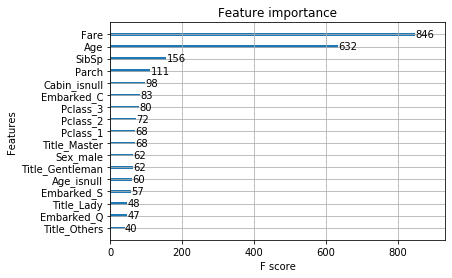

In [200]:
# variable importance
xgb.plot_importance(xgb_grid.best_estimator_)

In [201]:
xgb_grid.best_score_

0.8462796504369539

In [204]:
# prediction on the test set
test_predict = pd.Series(xgb_grid.predict(data_test), name="Survived")
id = Data_test['PassengerId']

prediction = pd.concat([id, test_predict], axis=1)

In [205]:
# generate output file for Kaggle
prediction.to_csv('prediction_xgb.csv', index=False)

### Score: 0.79904 (1489)
### Rank: 1489 / 16514